<a href="https://colab.research.google.com/github/DrAlexSanz/nlpv2-course/blob/master/Sentiment_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [50]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, f1_score, confusion_matrix, ConfusionMatrixDisplay, RocCurveDisplay
from sklearn.naive_bayes import ComplementNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from wordcloud import WordCloud

In [51]:
# Get the data

!wget https://lazyprogrammer.me/course_files/AirlineTweets.csv

--2022-08-05 12:02:28--  https://lazyprogrammer.me/course_files/AirlineTweets.csv
Resolving lazyprogrammer.me (lazyprogrammer.me)... 172.67.213.166, 104.21.23.210, 2606:4700:3031::6815:17d2, ...
Connecting to lazyprogrammer.me (lazyprogrammer.me)|172.67.213.166|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3421431 (3.3M) [text/csv]
Saving to: ‘AirlineTweets.csv.3’

AirlineTweets.csv.3 100%[===================>]   3.26M  2.35MB/s    in 1.4s    

2022-08-05 12:02:30 (2.35 MB/s) - ‘AirlineTweets.csv.3’ saved [3421431/3421431]



In [52]:
df_ = pd.read_csv("AirlineTweets.csv")

In [53]:
df_.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


In [54]:
df = df_[["airline_sentiment", "text"]].copy() # I can probably improve the model using hte sentiment confidence column
df.head()

,airline_sentiment,text
0,neutral,@VirginAmerica What @dhepburn said.
1,positive,@VirginAmerica plus you've added commercials t...
2,neutral,@VirginAmerica I didn't today... Must mean I n...
3,negative,@VirginAmerica it's really aggressive to blast...
4,negative,@VirginAmerica and it's a really big bad thing...


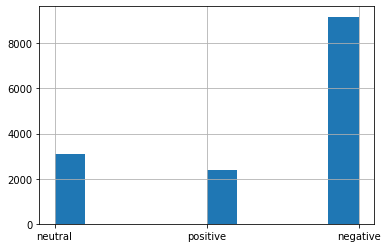

In [55]:
# See if it's 50-50

df["airline_sentiment"].hist() # There are a lot of negative examples. What a surprise! Being twitter data...

In [56]:
# Create numeric labels. Some libraries don't need this step
target_map = {"positive": 1, "negative": 0, "neutral": 2} # Mapping is arbitrary

df["target"] = df["airline_sentiment"].map(target_map)

In [57]:
df.head()

,airline_sentiment,text,target
0,neutral,@VirginAmerica What @dhepburn said.,2
1,positive,@VirginAmerica plus you've added commercials t...,1
2,neutral,@VirginAmerica I didn't today... Must mean I n...,2
3,negative,@VirginAmerica it's really aggressive to blast...,0
4,negative,@VirginAmerica and it's a really big bad thing...,0


In [58]:
# Split data

df_train, df_test = train_test_split(df,test_size = 0.2)
df_train.head()

,airline_sentiment,text,target
11690,negative,@USAirways yes I can pay out of pocket that us...,0
511,negative,@united you think you boarded flight AU1066 to...,0
637,negative,@united ours in July. You have ZERO excuses fo...,0
3506,neutral,@united @staralliance good. Maybe that will m...,2
12041,neutral,@AmericanAir we've already made other arrangem...,2


In [59]:
# Create training matrix

featurizer = TfidfVectorizer(max_features = 2000) # Limit the vocab size
x_train = featurizer.fit_transform(df_train["text"])
x_test = featurizer.transform(df_test["text"])
y_train = df_train["target"]
y_test = df_test["target"]
x_train


<11712x2000 sparse matrix of type '<class 'numpy.float64'>'
	with 168472 stored elements in Compressed Sparse Row format>

In [60]:
model = LogisticRegression(max_iter = 500)
model_CNB = ComplementNB() # This one is in theory good for imbalanced classes
model_RF = RandomForestClassifier(n_estimators = 200, class_weight = "balanced")

model.fit(x_train, y_train)
print("Train accuracy = ", model.score(x_train, y_train))
print("Test accuracy = ", model.score(x_test, y_test))

model_CNB.fit(x_train, y_train)
print("Train_CNB accuracy = ", model_CNB.score(x_train, y_train))
print("Test_CNB accuracy = ", model_CNB.score(x_test, y_test))

model_RF.fit(x_train, y_train)
print("Train_RF accuracy = ", model_RF.score(x_train, y_train))
print("Test_RF accuracy = ", model_RF.score(x_test, y_test))

Train accuracy =  0.853910519125683
Test accuracy =  0.8066939890710383
Train_CNB accuracy =  0.8177937158469946
Test_CNB accuracy =  0.780396174863388
Train_RF accuracy =  0.9956454918032787
Test_RF accuracy =  0.7687841530054644


Keep in mind, this is accuracy and it's imbalanced. Look at confusion matrix

In [61]:
pred_train = model.predict(x_train)
pred_test = model.predict(x_test)
print("Train f1 score = ", f1_score(y_train, pred_train, average = "micro")) # Just a few
print("Test f1 score", f1_score(y_test, pred_test, average = "micro"))

pred_train_CNB = model_CNB.predict(x_train)
pred_test_CNB = model_CNB.predict(x_test)
print("Train_CNB f1 score = ", f1_score(y_train, pred_train_CNB, average = "weighted"))
print("Test_CNB f1 score", f1_score(y_test, pred_test_CNB, average = "weighted"))

pred_train_RF = model_RF.predict(x_train)
pred_test_RF = model_RF.predict(x_test)
print("Train_RF f1 score = ", f1_score(y_train, pred_train_RF, average = "macro"))
print("Test_RF f1 score", f1_score(y_test, pred_test_RF, average = "macro"))

Train f1 score =  0.853910519125683
Test f1 score 0.8066939890710383
Train_CNB f1 score =  0.818551228585329
Test_CNB f1 score 0.7810190801409646
Train_RF f1 score =  0.9931856635933083
Test_RF f1 score 0.6713607158381207


In [62]:
prob_train = model.predict_proba(x_train)#[:, 1] # We don't want to take only the first column, it's a multiclass classification
prob_test = model.predict_proba(x_test)#[:, 1]

print("Train AUC = ", roc_auc_score(y_train, prob_train, multi_class = "ovo")) # Can use OVR. I'm not going to look into it now.
print("Test AUC = ", roc_auc_score(y_test, prob_test, multi_class = "ovo"))

prob_train_CNB = model_CNB.predict_proba(x_train)#[:, 1]
prob_test_CNB = model_CNB.predict_proba(x_test)#[:, 1]

print("Train AUC = ", roc_auc_score(y_train, prob_train_CNB, multi_class = "ovo"))
print("Test AUC = ", roc_auc_score(y_test, prob_test_CNB, multi_class = "ovo"))

prob_train_RF = model_RF.predict_proba(x_train)#[:, 1]
prob_test_RF = model_RF.predict_proba(x_test)#[:, 1]

print("Train AUC_RF = ", roc_auc_score(y_train, prob_train_RF, multi_class = "ovo"))
print("Test AUC_RF = ", roc_auc_score(y_test, prob_test_RF, multi_class = "ovo"))

Train AUC =  0.9410396382836087
Test AUC =  0.9016622873164225
Train AUC =  0.9100398741862374
Test AUC =  0.8821142363113711
Train AUC_RF =  0.9986141722644089
Test AUC_RF =  0.873719673795624


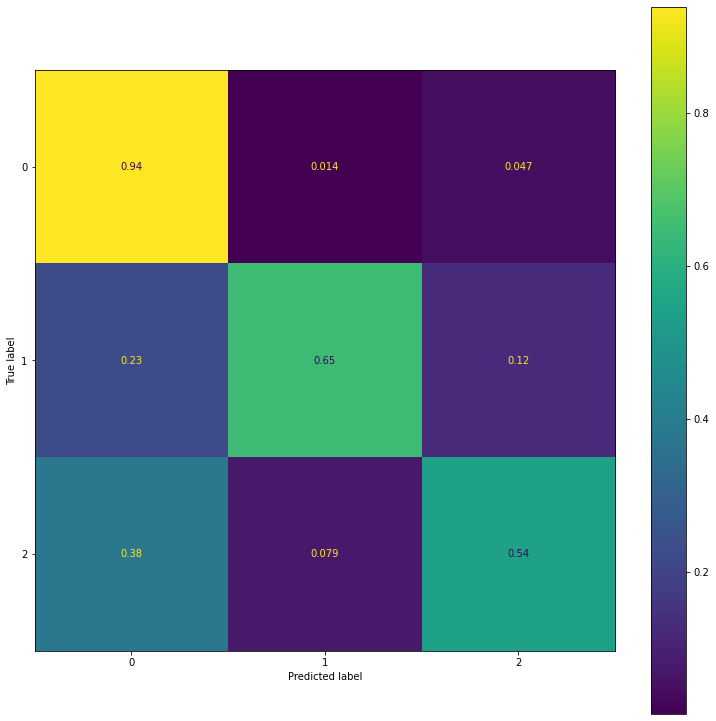

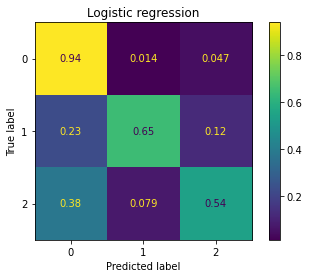

In [63]:
fig, ax = plt.subplots(figsize = (13, 13))
cm = ConfusionMatrixDisplay.from_estimator(model, x_test, y_test, normalize = "true") # %s instead of numbers
plt.title("Logistic regression")
cm.plot(ax = ax)

# See how the biggest problem is in class predicted 0 when it should be 2 adn predicted 0 when it should be 1

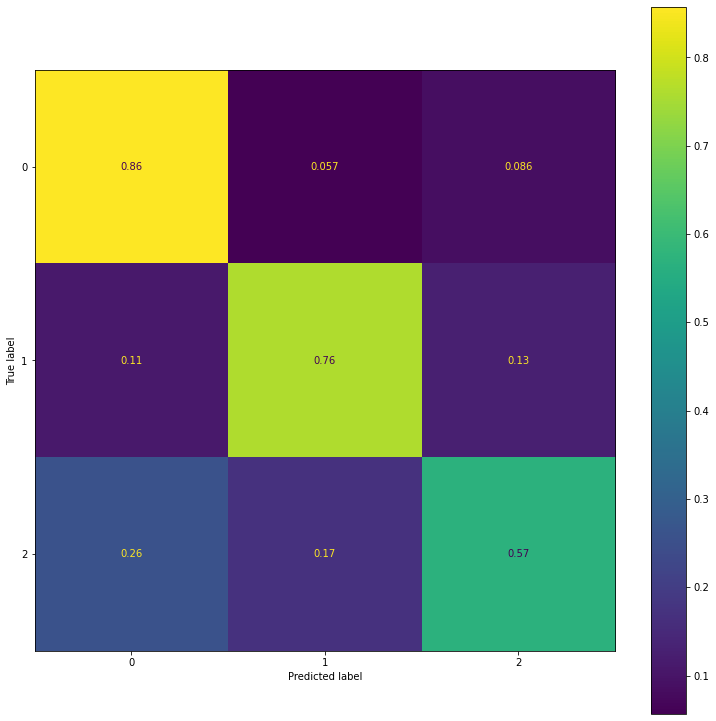

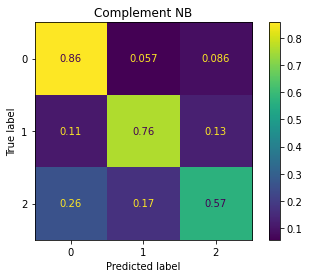

In [64]:
fig, ax = plt.subplots(figsize = (13, 13))
cm = ConfusionMatrixDisplay.from_estimator(model_CNB, x_test, y_test, normalize = "true") # %s instead of numbers
plt.title("Complement NB")
cm.plot(ax = ax)

# See how the biggest problem is again in class predicted 0 when it should be 2 and how class predicted 0 when it should be 1 is comparable to predicted 1 when it should be 1

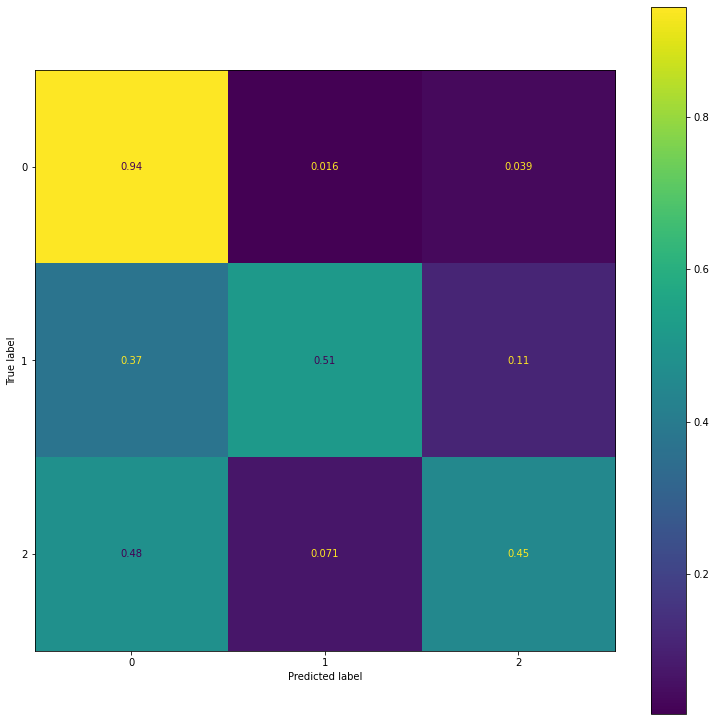

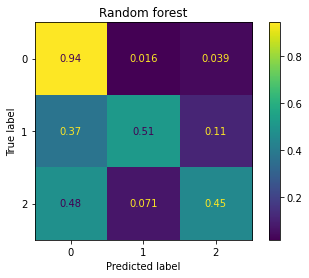

In [65]:
fig, ax = plt.subplots(figsize = (13, 13))
cm = ConfusionMatrixDisplay.from_estimator(model_RF, x_test, y_test, normalize = "true") # %s instead of numbers
plt.title("Random forest")
cm.plot(ax = ax)

# See how the biggest problem is the same as the logistic regression

## Now let's make a binary model to discriminate between positive and negative for simplicity of the interpretation

In [67]:
binary_target_list = [target_map["positive"], target_map["negative"]]
df_b_train = df_train[df_train["target"].isin(binary_target_list)]
df_b_test = df_test[df_test["target"].isin(binary_target_list)]

In [68]:
df_b_train.head()

,airline_sentiment,text,target
11690,negative,@USAirways yes I can pay out of pocket that us...,0
511,negative,@united you think you boarded flight AU1066 to...,0
637,negative,@united ours in July. You have ZERO excuses fo...,0
11130,negative,@USAirways has the most ass backwards process ...,0
3406,negative,"@united unfortunately, that doesn't help. Just...",0


In [74]:
x_train = featurizer.fit_transform(df_b_train["text"])
x_test = featurizer.transform(df_b_test["text"])
y_train = df_b_train["target"]
y_test = df_b_test["target"]
x_train

<9249x2000 sparse matrix of type '<class 'numpy.float64'>'
	with 140214 stored elements in Compressed Sparse Row format>

And now let's do the same analysis on a binary dataset. Results should be better but keep in mind that the classes are still imbalanced

In [75]:
model = LogisticRegression(max_iter = 500)
model_CNB = ComplementNB() # This one is in theory good for imbalanced classes
model_RF = RandomForestClassifier(n_estimators = 200, class_weight = "balanced")

model.fit(x_train, y_train)
print("Train accuracy = ", model.score(x_train, y_train))
print("Test accuracy = ", model.score(x_test, y_test))

model_CNB.fit(x_train, y_train)
print("Train_CNB accuracy = ", model_CNB.score(x_train, y_train))
print("Test_CNB accuracy = ", model_CNB.score(x_test, y_test))

model_RF.fit(x_train, y_train)
print("Train_RF accuracy = ", model_RF.score(x_train, y_train))
print("Test_RF accuracy = ", model_RF.score(x_test, y_test))

Train accuracy =  0.9291815331387177
Test accuracy =  0.9184118673647469
Train_CNB accuracy =  0.911666126067683
Test_CNB accuracy =  0.9018324607329843
Train_RF accuracy =  0.9993512812195913
Test_RF accuracy =  0.8961605584642234


In [78]:
pred_train = model.predict(x_train)
pred_test = model.predict(x_test)
print("Train f1 score = ", f1_score(y_train, pred_train, average = "binary")) # Just a few
print("Test f1 score", f1_score(y_test, pred_test, average = "binary"))

pred_train_CNB = model_CNB.predict(x_train)
pred_test_CNB = model_CNB.predict(x_test)
print("Train_CNB f1 score = ", f1_score(y_train, pred_train_CNB, average = "binary"))
print("Test_CNB f1 score", f1_score(y_test, pred_test_CNB, average = "binary"))

pred_train_RF = model_RF.predict(x_train)
pred_test_RF = model_RF.predict(x_test)
print("Train_RF f1 score = ", f1_score(y_train, pred_train_RF, average = "binary"))
print("Test_RF f1 score", f1_score(y_test, pred_test_RF, average = "binary"))

Train f1 score =  0.8022939933594929
Test f1 score 0.7617834394904459
Train_CNB f1 score =  0.8085305835481603
Test_CNB f1 score 0.782608695652174
Train_RF f1 score =  0.9984260230849947
Test_RF f1 score 0.6860158311345645


In [79]:
model.coef_

array([[-0.32232214,  0.62462645, -0.21355339, ..., -0.1716569 ,
        -0.07741507, -0.47544996]])

(array([  1.,   1.,   1.,   2.,   4.,   5.,  24.,  46., 132., 583., 694.,
        303., 124.,  49.,  10.,   4.,   4.,   5.,   2.,   1.,   2.,   0.,
          0.,   1.,   0.,   0.,   0.,   0.,   0.,   2.]),
 array([-4.47601262, -4.05086825, -3.62572389, -3.20057953, -2.77543517,
        -2.35029081, -1.92514644, -1.50000208, -1.07485772, -0.64971336,
        -0.224569  ,  0.20057536,  0.62571973,  1.05086409,  1.47600845,
         1.90115281,  2.32629717,  2.75144154,  3.1765859 ,  3.60173026,
         4.02687462,  4.45201898,  4.87716334,  5.30230771,  5.72745207,
         6.15259643,  6.57774079,  7.00288515,  7.42802952,  7.85317388,
         8.27831824]),
 <a list of 30 Patch objects>)

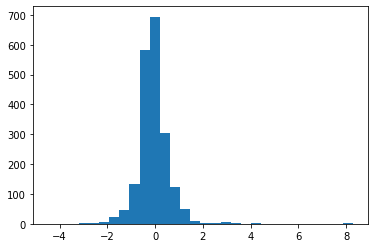

In [80]:
plt.hist(model.coef_[0], bins = 30) # Most of the weights are around 0 but I have some outliers

Let's have a look at the words that are determining if a tweet is positive or not.

In [81]:
# First get a word to index map

word_index_map = featurizer.vocabulary_
word_index_map # Key is the word, value is the index

{'usairways': 1866,
 'yes': 1989,
 'can': 315,
 'pay': 1305,
 'out': 1274,
 'of': 1234,
 'that': 1730,
 'us': 1864,
 'not': 1218,
 'helping': 873,
 'me': 1109,
 'for': 757,
 'my': 1185,
 'first': 719,
 'class': 376,
 'ticket': 1755,
 'to': 1766,
 'coach': 390,
 'want': 1898,
 'resolution': 1471,
 'or': 1263,
 'comp': 403,
 'united': 1845,
 'you': 1994,
 'think': 1741,
 'boarded': 268,
 'flight': 728,
 'too': 1773,
 'early': 597,
 'so': 1610,
 'in': 933,
 'have': 854,
 'zero': 1999,
 'excuses': 655,
 'this': 1744,
 'an': 145,
 'date': 487,
 'system': 1700,
 'problems': 1385,
 'like': 1039,
 'has': 849,
 'the': 1732,
 'most': 1172,
 'ass': 191,
 'process': 1386,
 'using': 1872,
 'on': 1250,
 'flights': 740,
 'even': 638,
 'trying': 1811,
 'get': 800,
 'hold': 885,
 'customer': 476,
 'relations': 1452,
 'is': 960,
 'impossible': 930,
 'unfortunately': 1841,
 'doesn': 566,
 'help': 870,
 'just': 983,
 'automated': 206,
 'computer': 414,
 'delays': 507,
 'less': 1026,
 'than': 1725,
 'becau

In [82]:
# Find the words with the largest magnitude weights

threshold = 2 # I can use percentiles too

for word, index in word_index_map.items(): # Investigate why I see airlines names?
    weight = model.coef_[0][index]
    if weight > threshold:
        print(word, weight)

thanks 7.932195408338527
virginamerica 3.3465525704967316
jetblue 3.0970784173561654
thank 8.278318238639871
southwestair 2.9624896809934547
thx 2.689428428632729
love 4.395919652495865
appreciate 3.0077852468783135
great 5.662276361597046
good 2.815118134062971
nice 2.207173088301825
best 3.632276169290155
amazing 3.452195738102486
kudos 2.722735218296528
wonderful 2.4292101048885253
awesome 4.243751902324436
happy 2.0235184167636753
excellent 2.3550430200144477
worries 2.8947419395074934


In [84]:
# Do the same with -threshold for negative weights

for word, index in word_index_map.items(): # Investigate why I see airlines names?
    weight = model.coef_[0][index]
    if weight < -threshold:
        print(word, weight)

not -4.4760126155593705
hold -2.7363072763726173
no -3.825461588711869
cancelled -2.709970492330281
why -2.5282168511265177
hours -3.358592439937871
delayed -2.876715866837955
don -2.072392102103328
nothing -2.3768219506185955
what -2.214343557505189
worst -3.069584046837448
luggage -2.20138340063273
